In [6]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [8]:
!pwd

/home/myralllka/Documents/Progn/dl_fb


In [4]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [5]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

FileNotFoundError: [Errno 2] File b'data/production_good.csv' does not exist: b'data/production_good.csv'

In [4]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [5]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [6]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
DATA['Johor']

(            Johor_Month  Johor_Area_ma  Johor_Area_npa  Johor_Area_rpa  \
 1999-01-01            1     574.000000      613.000000        7.000000   
 1999-02-01            2     574.000000      613.000000        7.000000   
 1999-03-01            3     574.000000      613.000000        7.000000   
 1999-04-01            4     574.000000      613.000000        7.000000   
 1999-05-01            5     574.000000      613.000000        7.000000   
 ...                 ...            ...             ...             ...   
 2017-05-01            5     614.631579      683.684211       14.947368   
 2017-06-01            6     614.631579      683.684211       14.947368   
 2017-07-01            7     614.631579      683.684211       14.947368   
 2017-08-01            8     614.631579      683.684211       14.947368   
 2017-09-01            9     614.631579      683.684211       14.947368   
 
             Johor_Area_ma_new  Johor_Time  Johor_Rainfall_6  Johor_Rainfall_7  \
 1999-01-01     

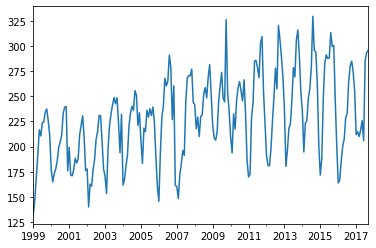

In [7]:
ts = DATA['Johor'][1]
ts.plot()

In [8]:
from fbprophet import Prophet

m = Prophet(seasonality_mode='multiplicative',
            growth='logistic',
            yearly_seasonality=True,
            daily_seasonality=True)

m.add_country_holidays(country_name='US')
m.add_seasonality(name='monthly', period=4, fourier_order=5)

val_interval = 6

train_index = ts.index[:-6]
test_index = ts.index[-6:]

train_val = ts.values[:-6]
test_val = ts.values[-6:]

ptrain = pd.DataFrame()
ptrain["ds"] = train_index
ptrain["y"] = train_val

ptrain['floor'] = ptrain['y'].min()
ptrain['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

# ptrain['floor']=0
# ptrain['cap']=8000

m.fit(ptrain)

/usr/local/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


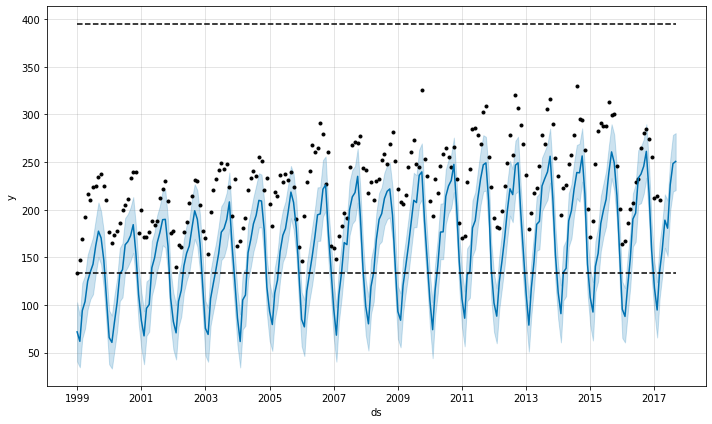

In [10]:
future = m.make_future_dataframe(periods=val_interval, include_history=True, freq="m")
future['floor'] = ptrain['y'].min()
future['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

fig1 = m.plot(forecast)

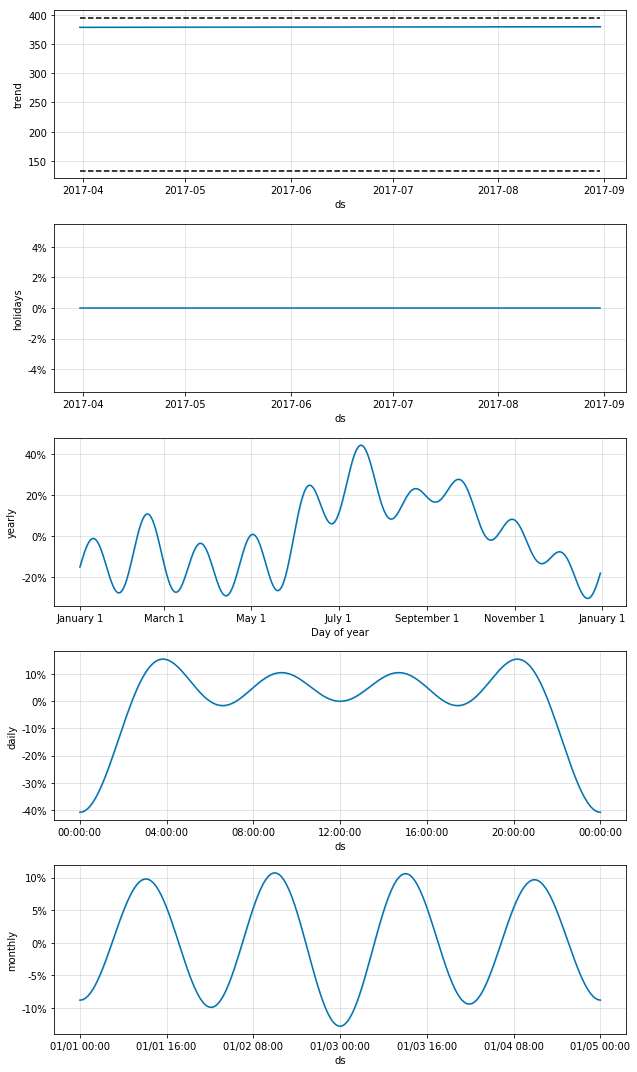

In [11]:
fig = m.plot_components(forecast)

In [12]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-03-31,378.711741,395.382,133.109,129.765681,188.716325,378.711741,378.711741,0.0,0.0,...,-0.582940,-0.582940,-0.582940,-0.075962,-0.075962,-0.075962,0.0,0.0,0.0,157.945464
1,2017-04-30,378.917297,395.382,133.109,160.036197,218.494508,378.917297,378.917297,0.0,0.0,...,-0.501104,-0.501104,-0.501104,0.000819,0.000819,0.000819,0.0,0.0,0.0,189.040140
2,2017-05-31,379.127219,395.382,133.109,153.684322,209.450920,379.127219,379.127219,0.0,0.0,...,-0.523646,-0.523646,-0.523646,0.012450,0.012450,0.012450,0.0,0.0,0.0,180.598619
3,2017-06-30,379.327987,395.382,133.109,196.692102,253.665068,379.327987,379.327987,0.0,0.0,...,-0.403917,-0.403917,-0.403917,0.092120,0.092120,0.092120,0.0,0.0,0.0,226.111103
4,2017-07-31,379.533010,395.382,133.109,219.282838,277.911010,379.533010,379.533010,0.0,0.0,...,-0.345557,-0.345557,-0.345557,0.156367,0.156367,0.156367,0.0,0.0,0.0,248.382665
5,2017-08-31,379.735581,395.382,133.109,223.514681,280.097511,379.735581,379.735581,0.0,0.0,...,-0.339755,-0.339755,-0.339755,0.196342,0.196342,0.196342,0.0,0.0,0.0,250.718641


In [11]:
forecast[["ds", "yhat"]]

,ds,yhat
0,1999-01-01,71.749821
1,1999-02-01,61.819665
2,1999-03-01,94.079285
3,1999-04-01,103.554266
4,1999-05-01,124.949853
...,...,...
220,2017-04-30,189.040140
221,2017-05-31,180.598619
222,2017-06-30,226.111103
223,2017-07-31,248.382665
